# 1D EM Inversion
## LIN Approximation
### Sensitivity to $\sigma$ example

In [36]:
import numpy as np
import empymod
import matplotlib.pyplot as plt
from scipy.constants import mu_0
import pygimli as pg

In [37]:
# Receivers geometry

offsets = np.array([2, 4, 8]) # in meters
height = 0.10 # meter height from ground surface to center of coil
rad = 0.08 # Define radius of coil

# For HCP
Hsource = [-rad, rad, -rad, rad, -height, -height]
Hreceivers =[offsets-rad, offsets+rad, np.ones(3)*-rad, np.ones(3)*rad, -height, -height]

# For VCP
Vsource = [0, 0, -height, 90, 0]
Vreceivers = [offsets, offsets*0, -height, 90, 0]

# For PRP
Psource = [0, 0, -height]
Preceivers = [offsets+0.1, offsets*0, -height]

# Frequency
freq = 9000

In [38]:
# Define cummulative sensitivity functions

# z is the normalized depth with respect to coil separation (depth/coil sep)

def CS_PRP(z):
    CS = 2*z / (np.sqrt(4 * z**2 + 1))
    return CS
    
def CS_HCP(z):
    CS = 1 - 1/(np.sqrt(4 * z**2 + 1))
    return CS
    
def CS_VCP(z):
    CS = 1 - (np.sqrt(4 * z**2 + 1) - 2*z)
    return CS

# LIN approximation function
# Calculates an apparent conductivity from Quadrature values
def Sigma_from_Q(Q, freq, mu_0, s):
    sigma_app = 4 * Q / ((2 * np.pi * freq) * mu_0 * s**2)
    return sigma_app

def Q_from_Sigma(sigma, freq, mu_0, s):
    Q = sigma * (2 *np.pi * freq) * mu_0 * s**2 /4
    return Q

In [39]:
# Define forward function

# Parameters: 3 conductivities, 2 thicknesses

def LIN_Forward(sigma1, sigma2, sigma3, thick1, thick2, height=height):
    # returns apparent conductivities for each coil geometry and separation
    # height represents separation of coils from ground surface
    
    sigma1 = sigma1/1000
    sigma2 = sigma2/1000
    sigma3 = sigma3/1000
    
    Q_HCP = []
    Q_VCP = []
    Q_PRP = []
    
    for coil in offsets:
        # Calculate apparent conductivity PRP geometry
        sig_app_PRP = sigma1 * (CS_PRP((height + thick1)/(coil+0.1)) - CS_PRP(height/(coil+0.1))) \
                    + sigma2 * (CS_PRP((height + thick1 + thick2)/(coil+0.1)) - CS_PRP((height + thick1)/(coil+0.1))) \
                    + sigma3 * (1 - CS_PRP((height + thick1 + thick2)/(coil+0.1)))

        # Calculate apparent conductivity HCP geometry
        sig_app_HCP = sigma1 * (CS_HCP((height + thick1)/coil) - CS_HCP(height/coil)) \
                    + sigma2 * (CS_HCP((height + thick1 + thick2)/coil) - CS_HCP((height + thick1)/coil)) \
                    + sigma3 * (1 - CS_HCP((height + thick1 + thick2)/coil))

        # Calculate apparent conductivity VCP geometry
        sig_app_VCP = sigma1 * (CS_VCP((height + thick1)/coil) - CS_VCP(height/coil)) \
                    + sigma2 * (CS_VCP((height + thick1 + thick2)/coil) - CS_VCP((height + thick1)/coil)) \
                    + sigma3 * (1 - CS_VCP((height + thick1 + thick2)/coil))
                
        Q_HCP.append(Q_from_Sigma(sig_app_HCP, freq, mu_0, coil))
        Q_VCP.append(Q_from_Sigma(sig_app_VCP, freq, mu_0, coil))
        Q_PRP.append(Q_from_Sigma(sig_app_PRP, freq, mu_0, coil+0.1))
            
    return np.hstack((Q_HCP, Q_VCP, Q_PRP))

## Compare with empymod

In [40]:
def Analytic_Forward(sigma1, sigma2, sigma3, thick1, thick2, height=height):
    # Returns apparent conductivity for each coil geometry and separation
    
    sigma1 = sigma1/1000
    sigma2 = sigma2/1000
    sigma3 = sigma3/1000
    
    surface = 0
    depth = [surface, thick1, thick1 + thick2]
    res_air = 2e14
    res = [res_air, 1/sigma1, 1/sigma2, 1/sigma3]
    HCP_Hs = empymod.loop(Hsource, Hreceivers, depth, res, freq, xdirect=None, mrec = 'loop', verb=0)
    VCP_Hs = empymod.loop(Vsource, Vreceivers, depth, res, freq, xdirect=None, mrec = 'loop', verb=0)
    PRP_Hs = empymod.dipole(Psource, Preceivers, depth, res, freq, ab = 64, xdirect = None, verb = 0)

    HCP_Hp = empymod.loop(Hsource, Hreceivers, depth=[], res=[res_air], freqtime=freq, mrec = 'loop', verb=0)
    VCP_Hp = empymod.loop(Vsource, Vreceivers, depth=[], res=[res_air], freqtime=freq, mrec = 'loop', verb=0)
    PRP_Hp = empymod.dipole(Psource, Preceivers, depth=[], res=[res_air], freqtime = freq, ab = 66, verb = 0)

    Q_HCP = -np.imag(HCP_Hs/HCP_Hp)
    Q_VCP = np.imag(VCP_Hs/VCP_Hp)
    Q_PRP = np.imag(PRP_Hs/PRP_Hp)

    return np.hstack((Q_HCP, Q_VCP, Q_PRP))

In [41]:
sigma1 = 20
sigma2 = 80
sigma3 = 20
thick1 = 2
thick2 = 2

In [42]:
LIN_Forward(sigma1, sigma2, sigma3, thick1, thick2)

array([0.00223696, 0.00996247, 0.03549442, 0.00173708, 0.00829171,
       0.03564697, 0.00176765, 0.00888639, 0.04029783])

In [43]:
Analytic_Forward(sigma1, sigma2, sigma3, thick1, thick2)

array([0.00213341, 0.0091376 , 0.02900923, 0.00168526, 0.00787798,
       0.03237209, 0.00176448, 0.00884086, 0.0396327 ])

## Define initial model

In [47]:
# parameters for the synthetic model

nlayer = 3 # number of layer
npos = 20 # number of sampling positions

sig_ini = [1, 10, 1]
sigmas = np.ones((npos, nlayer))*sig_ini
x = np.linspace(0, 20, npos)[:,None]
thk1 = np.ones_like(x)*2 # wave
thk2 = np.ones_like(x)*2    # wave
depthmax = 10
ny = 50
sig_mid_lay = np.linspace(1, 10, npos)[:, None]

for i in range(npos):
    sigmas[i][1] = sig_mid_lay[i]

In [48]:
# Arrays for plotting
y = np.linspace(0, depthmax, ny)
xx = np.linspace(0,npos+1,npos+1, endpoint=False) # For step plot

def PlotModel(thk1, thk2, sigmas, npos, ny, Model, vmin=0.1, vmax=20):
    surface = np.zeros(npos)
    depth = np.zeros((npos,4))

    # Depths to be plotted
    for i in range(npos):
        depth[i,0] = 0
        depth[i,1] = thk1[i]
        depth[i,2] = thk1[i] + thk2[i]
        depth[i,3] = thk1[i] + thk2[i]
        
    sigy = np.zeros((npos, ny))

    # Conductivities array to be plotted
    for i in range(npos):
        y1=0
        while y[y1] <= depth[i, 1]:
            sigy[i, y1] = sigmas[i, 0]
            y1 += 1
            y2=y1
        while y[y2] <= depth[i, 2]:
            sigy[i, y2] = sigmas[i, 1]
            y2 += 1
            if y2 == 50:
                break
        sigy[i, y2:] = sigmas[i, 2]
        
    fig, ax = plt.subplots()
    pos = ax.imshow(sigy.T, cmap='viridis', interpolation='none', extent=[0,npos,10,0], vmin =vmin, vmax=vmax)
    clb = fig.colorbar(pos, shrink=0.5)
    clb.set_label('Conductivity [mS/m]',  )
    ax.set_ylabel('Depth [m]')
    ax.set_xlabel('Position [m]')
    ax.set_title(Model)
        
    return depth, sigy

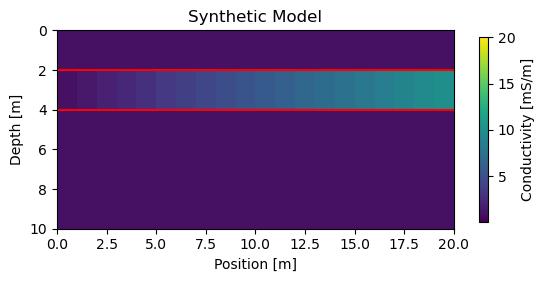

In [49]:
#Plot synthetic model

depth, sigy = PlotModel(thk1, thk2, sigmas, npos, ny, 'Synthetic Model')

plt.step(np.hstack((xx, xx[-1])), np.hstack((depth[0,1],depth[:,1],depth[-1,1])), 'r')
plt.step(np.hstack((xx, xx[-1])), np.hstack((depth[0,1],depth[:,2],depth[-1,2])),'r')


In [50]:
# Data normalization

# Create empty array for true data in each position
data = []
data_LIN = []

for i in range(npos):
    model_i = np.hstack((sigmas[i], thk1[i], thk2[i])) # True model 
    data.append(Analytic_Forward(sigmas[i][0], sigmas[i][1], sigmas[i][2], thk1[i], thk2[i])) # creating data
    data_LIN.append(LIN_Forward(sigmas[i][0], sigmas[i][1], sigmas[i][2], thk1[i], thk2[i]))

data=np.array(data)
data_LIN= np.array(data_LIN)

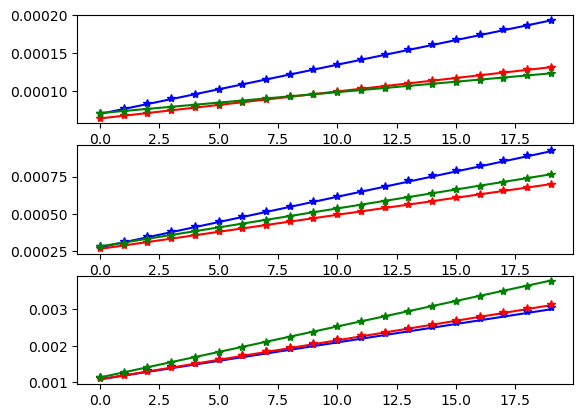

In [51]:
# Let's compare the data
fig, (ax1, ax2, ax3)=plt.subplots(3,1)

ax1.plot(data[:,0], 'b',label='HCP 2m Analytic')
ax1.plot(data[:,3], 'r',label='VCP 2m Analytic')
ax1.plot(data[:,6], 'g',label='PRP 2m Analytic')
ax1.plot(data_LIN[:,0,0], '*b',label='HCP 2m LIN')
ax1.plot(data_LIN[:,0,1], '*r',label='VCP 2m LIN')
ax1.plot(data_LIN[:,0,2], '*g',label='PRP 2m LIN')

ax2.plot(data[:,1], 'b',label='HCP 4m Analytic')
ax2.plot(data[:,4], 'r',label='VCP 4m Analytic')
ax2.plot(data[:,7], 'g',label='PRP 2m Analytic')
ax2.plot(data_LIN[:,1,0], '*b',label='HCP 4m LIN')
ax2.plot(data_LIN[:,1,1], '*r',label='VCP 4m LIN')
ax2.plot(data_LIN[:,1,2], '*g',label='PRP 2m LIN')

ax3.plot(data[:,2], 'b',label='HCP 8m Analytic')
ax3.plot(data[:,5], 'r',label='VCP 8m Analytic')
ax3.plot(data[:,8], 'g',label='PRP 2m Analytic')
ax3.plot(data_LIN[:,2,0], '*b',label='HCP 8m LIN')
ax3.plot(data_LIN[:,2,1], '*r',label='VCP 8m LIN')
ax3.plot(data_LIN[:,2,2], '*g',label='PRP 2m LIN')

In [52]:
# Calculate normalization by coil and OP /IP

data = np.array(data)

# data shape is (npos, geometries * 2) 

Q_HCP_2 = data[:,0]
Q_HCP_4 = data[:,1]
Q_HCP_8 = data[:,2]
Q_VCP_2 = data[:,3]
Q_VCP_4 = data[:,4]
Q_VCP_8 = data[:,5]
Q_PRP_2 = data[:,6]
Q_PRP_4 = data[:,7]
Q_PRP_8 = data[:,8]

# Calculate L2 norm

L2_Q_HCP_2 = np.sqrt(np.sum(Q_HCP_2**2))
L2_Q_HCP_4 = np.sqrt(np.sum(Q_HCP_4**2))
L2_Q_HCP_8 = np.sqrt(np.sum(Q_HCP_8**2))

L2_Q_VCP_2 = np.sqrt(np.sum(Q_VCP_2**2))
L2_Q_VCP_4 = np.sqrt(np.sum(Q_VCP_4**2))
L2_Q_VCP_8 = np.sqrt(np.sum(Q_VCP_8**2))

L2_Q_PRP_2 = np.sqrt(np.sum(Q_PRP_2**2))
L2_Q_PRP_4 = np.sqrt(np.sum(Q_PRP_4**2))
L2_Q_PRP_8 = np.sqrt(np.sum(Q_PRP_8**2))

L2_Q_HCP = np.hstack((L2_Q_HCP_2, L2_Q_HCP_4, L2_Q_HCP_8))
L2_Q_VCP = np.hstack((L2_Q_VCP_2, L2_Q_VCP_4, L2_Q_VCP_8))
L2_Q_PRP = np.hstack((L2_Q_PRP_2, L2_Q_PRP_4, L2_Q_PRP_8))

L2 = np.stack((L2_Q_HCP, L2_Q_VCP, L2_Q_PRP))

## Create forward modeller classes for both methods

In [53]:
def Analytic_Forward_norm(sigma1, sigma2, sigma3, thick1, thick2, height=height):
    # Returns apparent conductivity for each coil geometry and separation
    
    sigma1 = sigma1/1000
    sigma2 = sigma2/1000
    sigma3 = sigma3/1000
    
    surface = 0
    depth = [surface, thick1, thick1 + thick2]
    res_air = 2e14
    res = [res_air, 1/sigma1, 1/sigma2, 1/sigma3]
    HCP_Hs = empymod.loop(Hsource, Hreceivers, depth, res, freq, xdirect=None, mrec = 'loop', verb=0)
    VCP_Hs = empymod.loop(Vsource, Vreceivers, depth, res, freq, xdirect=None, mrec = 'loop', verb=0)
    PRP_Hs = empymod.dipole(Psource, Preceivers, depth, res, freq, ab = 64, xdirect = None, verb = 0)

    HCP_Hp = empymod.loop(Hsource, Hreceivers, depth=[], res=[res_air], freqtime=freq, mrec = 'loop', verb=0)
    VCP_Hp = empymod.loop(Vsource, Vreceivers, depth=[], res=[res_air], freqtime=freq, mrec = 'loop', verb=0)
    PRP_Hp = empymod.dipole(Psource, Preceivers, depth=[], res=[res_air], freqtime = freq, ab = 66, verb = 0)
   
    Q_HCP = -np.imag(HCP_Hs/HCP_Hp)/L2[0]
    Q_VCP = np.imag(VCP_Hs/VCP_Hp)/L2[1]
    Q_PRP = np.imag(PRP_Hs/PRP_Hp)/L2[2]
    
    return np.hstack((Q_HCP, Q_VCP, Q_PRP))

def LIN_Forward_norm(sigma1, sigma2, sigma3, thick1, thick2, height=height):
    # returns apparent conductivities for each coil geometry and separation
    # height represents separation of coils from ground surface
    
    sigma1 = sigma1/1000
    sigma2 = sigma2/1000
    sigma3 = sigma3/1000
    
    Q_HCP = []
    Q_VCP = []
    Q_PRP = []
    
    for coil in offsets:
        # Calculate apparent conductivity PRP geometry
        sig_app_PRP = sigma1 * (CS_PRP((height + thick1)/(coil+0.1)) - CS_PRP(height/(coil+0.1))) \
                    + sigma2 * (CS_PRP((height + thick1 + thick2)/(coil+0.1)) - CS_PRP((height + thick1)/(coil+0.1))) \
                    + sigma3 * (1 - CS_PRP((height + thick1 + thick2)/(coil+0.1)))

        # Calculate apparent conductivity HCP geometry
        sig_app_HCP = sigma1 * (CS_HCP((height + thick1)/coil) - CS_HCP(height/coil)) \
                    + sigma2 * (CS_HCP((height + thick1 + thick2)/coil) - CS_HCP((height + thick1)/coil)) \
                    + sigma3 * (1 - CS_HCP((height + thick1 + thick2)/coil))

        # Calculate apparent conductivity VCP geometry
        sig_app_VCP = sigma1 * (CS_VCP((height + thick1)/coil) - CS_VCP(height/coil)) \
                    + sigma2 * (CS_VCP((height + thick1 + thick2)/coil) - CS_VCP((height + thick1)/coil)) \
                    + sigma3 * (1 - CS_VCP((height + thick1 + thick2)/coil))
                
        Q_HCP.append(Q_from_Sigma(sig_app_HCP, freq, mu_0, coil))
        Q_VCP.append(Q_from_Sigma(sig_app_VCP, freq, mu_0, coil))
        Q_PRP.append(Q_from_Sigma(sig_app_PRP, freq, mu_0, coil+0.1))
        
    Q_HCP = Q_HCP/L2[0]
    Q_VCP = Q_VCP/L2[1]
    Q_PRP = Q_PRP/L2[2]
           
    return np.hstack((Q_HCP, Q_VCP, Q_PRP))

In [54]:
class LIN_Approx(pg.Modelling):
    
    def __init__(self):
        """Initialize the model."""
        super().__init__()
        
    def response(self, x):
        
        sigma1 = x[0]
        sigma2 = x[1]
        sigma3 = x[2]
        thick1 = x[3]
        thick2 = x[4]
        
        Q = LIN_Forward_norm(sigma1, sigma2, sigma3, thick1, thick2)

        return Q
        
    def createStartModel(self, dataVals):
        
        thk_ini = [2, 2]
        sig_ini = [10, 10, 10]
        x0 = sig_ini + thk_ini
        return np.array(x0)
    


## Define inversion

In [55]:
# Define inversion transformations

transData = pg.trans.TransLin() # log transformation for data
transModel = pg.trans.TransLog() # log-transform ensures thk>0

# Create inversion

LINf = LIN_Approx()
inv_LIN = pg.Inversion()
inv_LIN.setForwardOperator(LINf)
#inv_LIN.setDeltaPhiStop(0.01)
#inv_LIN.stopAtChi1=False

inv_LIN.transModel = transModel
inv_LIN.transData = transData




In [56]:
# Inputs for inversion:

# Create empty array for true model in each position
model = []

# Create empty array for true data in each position
data_norm = []

for i in range(npos):
    model_i = np.hstack((sigmas[i], thk1[i], thk2[i])) # True model 
    model.append(model_i)
    data_norm.append(Analytic_Forward_norm(sigmas[i][0], sigmas[i][1], sigmas[i][2], thk1[i], thk2[i])) # creating data

# Relative error array
error = 1e-2 # introduce here the error you want to test
relativeError = np.ones_like(data_norm[0]) * error

## Start Inversion with LIN Approximation

In [57]:
# Start inversion

model_est_list =[] # empty array to store the model estimated

for i in range(npos):
    
    dataE = data_norm[i].copy()
    dataE *= np.random.randn(len(dataE)) * relativeError + 1.0

    model_est = inv_LIN.run(dataE, relativeError, verbose=False, lam=1, maxIter=40)
    
    model_est_list.append(model_est)

# Model estimation array    
model_est_arr_LIN = np.array(model_est_list)

01/12/22 - 16:08:24 - pyGIMLi - INFO - Created startmodel from forward operator: [10 10 10  2  2]
01/12/22 - 16:08:24 - pyGIMLi - INFO - Created startmodel from forward operator: [10 10 10  2  2]
01/12/22 - 16:08:24 - pyGIMLi - INFO - Created startmodel from forward operator: [10 10 10  2  2]
01/12/22 - 16:08:24 - pyGIMLi - INFO - Created startmodel from forward operator: [10 10 10  2  2]
01/12/22 - 16:08:24 - pyGIMLi - INFO - Created startmodel from forward operator: [10 10 10  2  2]
01/12/22 - 16:08:24 - pyGIMLi - INFO - Created startmodel from forward operator: [10 10 10  2  2]
01/12/22 - 16:08:24 - pyGIMLi - INFO - Created startmodel from forward operator: [10 10 10  2  2]
01/12/22 - 16:08:24 - pyGIMLi - INFO - Created startmodel from forward operator: [10 10 10  2  2]
01/12/22 - 16:08:24 - pyGIMLi - INFO - Created startmodel from forward operator: [10 10 10  2  2]
01/12/22 - 16:08:24 - pyGIMLi - INFO - Created startmodel from forward operator: [10 10 10  2  2]
01/12/22 - 16:08:24 

01/12/22 - 16:08:24 - pyGIMLi - INFO - Created startmodel from forward operator: [10 10 10  2  2]


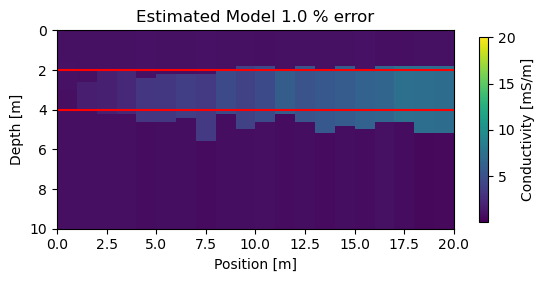

In [58]:
# Plot estimated model with LIN Approx

depth_,sigyLIN = PlotModel(model_est_arr_LIN[:,3], model_est_arr_LIN[:,4], model_est_arr_LIN[:,:3] , npos, ny,
                                 'Estimated Model ' + str(error*100) + ' % error')
plt.step(np.hstack((xx, xx[-1])), np.hstack((depth[0,1],depth[:,1],depth[-1,1])), 'r')
plt.step(np.hstack((xx, xx[-1])), np.hstack((depth[0,1],depth[:,2],depth[-1,2])), 'r')


In [59]:
# Plot Real data versus estimated model data

# Create empty array for true data in each position
data_LIN_est = []

data_HCP2m_Q=[]
data_HCP4m_Q=[]
data_HCP8m_Q=[]
data_VCP2m_Q=[]
data_VCP4m_Q=[]
data_VCP8m_Q=[]
data_PRP2m_Q=[]
data_PRP4m_Q=[]
data_PRP8m_Q=[]

data_HCP2m_Q_est=[]
data_HCP4m_Q_est=[]
data_HCP8m_Q_est=[]
data_VCP2m_Q_est=[]
data_VCP4m_Q_est=[]
data_VCP8m_Q_est=[]
data_PRP2m_Q_est=[]
data_PRP4m_Q_est=[]
data_PRP8m_Q_est=[]

for i in range(npos):
    model_i = model_est_arr_LIN[i] # True model 
    data_LIN_est.append(LINf(model_i)) # creating data

    data_HCP2m_Q.append(data_norm[i][0])
    data_HCP4m_Q.append(data_norm[i][1])
    data_HCP8m_Q.append(data_norm[i][2])
    data_VCP2m_Q.append(data_norm[i][3])
    data_VCP4m_Q.append(data_norm[i][4])
    data_VCP8m_Q.append(data_norm[i][5])
    data_PRP2m_Q.append(data_norm[i][6])
    data_PRP4m_Q.append(data_norm[i][7])
    data_PRP8m_Q.append(data_norm[i][8])
    
    data_HCP2m_Q_est.append(data_LIN_est[i][0])
    data_HCP4m_Q_est.append(data_LIN_est[i][1])
    data_HCP8m_Q_est.append(data_LIN_est[i][2])
    data_VCP2m_Q_est.append(data_LIN_est[i][3])
    data_VCP4m_Q_est.append(data_LIN_est[i][4])
    data_VCP8m_Q_est.append(data_LIN_est[i][5])
    data_PRP2m_Q_est.append(data_LIN_est[i][6])
    data_PRP4m_Q_est.append(data_LIN_est[i][7])
    data_PRP8m_Q_est.append(data_LIN_est[i][8])
    
    


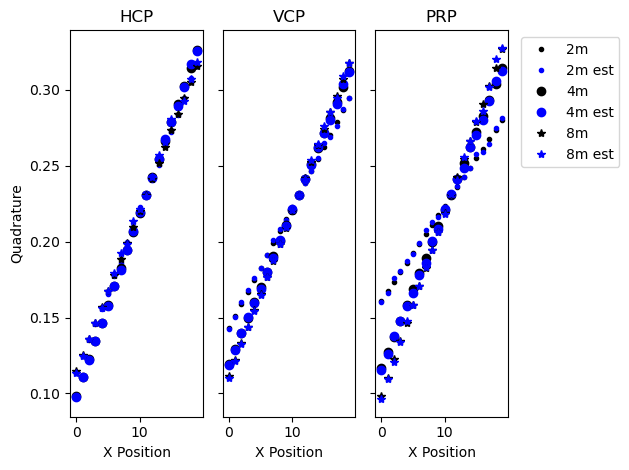

In [60]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True)

ax1.plot(data_HCP2m_Q, '.k' , label = '2m')
ax1.plot(data_HCP2m_Q_est, '.b', label = '2m est')
ax1.plot(data_HCP4m_Q, 'ok' , label = '4m')
ax1.plot(data_HCP4m_Q_est, 'ob', label = '4m est')
ax1.plot(data_HCP8m_Q, '*k' , label = '8m')
ax1.plot(data_HCP8m_Q_est, '*b', label = '8m est')
ax1.set_xlabel('X Position')
ax1.set_ylabel('Quadrature')

ax1.set_title('HCP')

ax2.plot(data_VCP2m_Q, '.k' , label = '2m')
ax2.plot(data_VCP2m_Q_est, '.b', label = '2m est')
ax2.plot(data_VCP4m_Q, 'ok' , label = '4m')
ax2.plot(data_VCP4m_Q_est, 'ob', label = '4m est')
ax2.plot(data_VCP8m_Q, '*k' , label = '8m')
ax2.plot(data_VCP8m_Q_est, '*b', label = '8m est')
ax2.set_xlabel('X Position')
#ax2.set_ylabel('Quadrature')
ax2.set_title('VCP')

ax3.plot(data_PRP2m_Q, '.k' , label = '2m')
ax3.plot(data_PRP2m_Q_est, '.b', label = '2m est')
ax3.plot(data_PRP4m_Q, 'ok' , label = '4m')
ax3.plot(data_PRP4m_Q_est, 'ob', label = '4m est')
ax3.plot(data_PRP8m_Q, '*k' , label = '8m')
ax3.plot(data_PRP8m_Q_est, '*b', label = '8m est')
ax3.set_xlabel('X Position')
#ax3.set_ylabel('Quadrature')
ax3.set_title('PRP')
ax3.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.tight_layout()